In [1]:
import pipeline as ppl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
from datetime import datetime

In [3]:
evaluations = pd.read_csv("../Data/RCRA_EVALUATIONS.csv")

In [4]:
meta = ppl.generate_metadata(evaluations)
summary = ppl.generate_summary(evaluations)
print("evaluations", "\n", "There are", len(evaluations), "observations of", len(meta), "variables:\n")
print(meta, "\n")
print("Summary of numeric variables\n", summary)

evaluations 
 There are 991196 observations of 8 variables:

                 colname           type  pct_null
0              ID_NUMBER  <class 'str'>       0.0
1      ACTIVITY_LOCATION  <class 'str'>       0.0
2  EVALUATION_IDENTIFIER  <class 'str'>       0.0
3        EVALUATION_TYPE  <class 'str'>       0.0
4        EVALUATION_DESC  <class 'str'>       0.0
5      EVALUATION_AGENCY  <class 'str'>       0.0
6  EVALUATION_START_DATE  <class 'str'>       0.0
7        FOUND_VIOLATION  <class 'str'>       0.0 

Summary of numeric variables
 None


In [6]:
evaluations['ACTIVITY_LOCATION'].value_counts()

NJ    72342
FL    64264
NC    55070
CO    52943
PA    47917
KY    46963
OH    40566
NY    39556
MI    36534
TN    34782
GA    32370
CA    30782
IL    29827
IN    25694
AL    24155
MA    22560
SC    18382
WA    18341
MO    18289
KS    17868
LA    17814
TX    17799
IA    16630
WV    16156
VA    16004
WI    15310
NV    14001
MN    13196
MT    12422
CT    11275
OR     9568
MD     9498
DC     9492
PR     9319
MS     6772
WY     5789
RI     5766
OK     5724
AR     5576
UT     5215
NM     4691
AZ     4628
NE     4494
ID     4207
VT     3853
DE     2932
ND     2492
HI     2207
SD     2094
AK     2016
NH     1955
ME     1893
GU      560
VI      404
NN      115
MP       80
TT       31
AS       13
Name: ACTIVITY_LOCATION, dtype: int64

In [5]:
evaluations['FOUND_VIOLATION'] = evaluations['FOUND_VIOLATION'].str.strip()
evaluations['ACTIVITY_LOCATION'] = evaluations['ACTIVITY_LOCATION'].str.strip()
evaluations['EVALUATION_IDENTIFIER'] = evaluations['EVALUATION_IDENTIFIER'].str.strip()
evaluations['EVALUATION_TYPE'] = evaluations['EVALUATION_TYPE'].str.strip()
evaluations['EVALUATION_AGENCY'] = evaluations['EVALUATION_AGENCY'].str.strip()

In [6]:
evaluations['VIOLATION_IND'] = np.where(evaluations['FOUND_VIOLATION']=="Y",1,0)

In [7]:
evaluations['DATE'] = pd.to_datetime(evaluations['EVALUATION_START_DATE'], errors='coerce')

In [8]:
evaluations_date = evaluations[evaluations['DATE']>='2000-01-01']

In [9]:
evaluations_date.head()

,ID_NUMBER,ACTIVITY_LOCATION,EVALUATION_IDENTIFIER,EVALUATION_TYPE,EVALUATION_DESC,EVALUATION_AGENCY,EVALUATION_START_DATE,FOUND_VIOLATION,VIOLATION_IND,DATE
6,MND006152334,MN,010,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,03/29/2000,Y,1,2000-03-29
7,MND006152334,MN,011,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,08/15/2001,Y,1,2001-08-15
8,MND006152334,MN,012,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,01/13/2004,Y,1,2004-01-13
10,MND006153415,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,E,06/05/2003,N,0,2003-06-05
11,MND006153415,MN,001,CEI,COMPLIANCE EVALUATION INSPECTION ON-SITE,S,12/29/2004,Y,1,2004-12-29


In [10]:
x = evaluations_date[['ACTIVITY_LOCATION','EVALUATION_IDENTIFIER','EVALUATION_TYPE','EVALUATION_AGENCY']]
x_dummy = ppl.dummify_categorical(x, ['ACTIVITY_LOCATION', 'EVALUATION_IDENTIFIER', 'EVALUATION_TYPE', 'EVALUATION_AGENCY'])
y = evaluations_date['VIOLATION_IND']

In [11]:
for depth in range(1,6):
    dtree = ppl.train_decision_tree(x_dummy, y, max_depth=depth)
    x_dummy.columns
    d = {'Features':x_dummy.columns, "Importance":dtree.feature_importances_}
    feature_importance = pd.DataFrame(data=d)
    feature_importance = feature_importance.sort_values(by=['Importance'], ascending=False)
    feature_importance = feature_importance[feature_importance['Importance'] > 0.0]
    print("Feature importance for decision tree with max_depth", depth, ":\n")
    print(feature_importance)
    print("--------------------------------------------------------")

Feature importance for decision tree with max_depth 1 :

                 Features  Importance
1126  EVALUATION_TYPE_CEI         1.0
--------------------------------------------------------
Feature importance for decision tree with max_depth 2 :

                       Features  Importance
1126        EVALUATION_TYPE_CEI    0.567708
1040  EVALUATION_IDENTIFIER_CEI    0.338643
16         ACTIVITY_LOCATION_IN    0.093648
--------------------------------------------------------
Feature importance for decision tree with max_depth 3 :

                       Features  Importance
1126        EVALUATION_TYPE_CEI    0.455267
1040  EVALUATION_IDENTIFIER_CEI    0.271571
1041  EVALUATION_IDENTIFIER_CEN    0.113498
16         ACTIVITY_LOCATION_IN    0.075100
38         ACTIVITY_LOCATION_OH    0.074975
1129        EVALUATION_TYPE_FRR    0.008007
9          ACTIVITY_LOCATION_FL    0.001582
--------------------------------------------------------
Feature importance for decision tree with max_depth 4 

In [22]:
x_train, x_test, y_train, y_test = ppl.create_date_splits(evaluations_date, ['ACTIVITY_LOCATION','EVALUATION_IDENTIFIER','EVALUATION_TYPE','EVALUATION_AGENCY'],
                                                         'VIOLATION_IND', 'DATE', ('01/01/2000','12/31/2015'), ('01/01/2016','12/31/2018'))

In [23]:
x_train = ppl.dummify_categorical(x_train, ['ACTIVITY_LOCATION', 'EVALUATION_IDENTIFIER', 'EVALUATION_TYPE', 'EVALUATION_AGENCY'])
x_test = ppl.dummify_categorical(x_test, ['ACTIVITY_LOCATION', 'EVALUATION_IDENTIFIER', 'EVALUATION_TYPE', 'EVALUATION_AGENCY'])

In [24]:
feature_importance_list = feature_importance['Features'].tolist()

In [26]:
top_features = feature_importance_list[:20]

In [27]:
dtree_summary_1 = ppl.decision_tree_loop(x_train[top_features], y_train, x_test[top_features], y_test, '01/01/2000-12/31/2015', '01/01/2016-12/31/2018', 
                                         ['gini','entropy'], ['best','random'], [1,2,3,5,10,None], [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5])

all_dtree = dtree_summary_1.sort_values(by='auc', axis=0, ascending=False)
top_dtree = all_dtree[:10]
print(top_dtree)

C:\Users\Alec\Documents\Academics\First Year\Spring Quarter\CAPP 30254 - Machine Learning\Project\Scripts\pipeline.py:1044: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 * tp / (fp + tp)
C:\Users\Alec\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alec\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alec\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alec\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-

             model             train_date              test_date criteria  \
40   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   
166  Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018  entropy   
124  Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018  entropy   
82   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   
165  Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018  entropy   
39   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   
123  Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018  entropy   
81   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   
68   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   
26   Decision Tree  01/01/2000-12/31/2015  01/01/2016-12/31/2018     gini   

    splitter max_depth  threshold  accuracy  precision    recall        f1  \
40      best      None        0.3  0.636049   0.401786  0.852815  0.546227

In [28]:
top_dtree

,model,train_date,test_date,criteria,splitter,max_depth,threshold,accuracy,precision,recall,f1,auc
40,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,best,None,0.3,0.636049,0.401786,0.852815,0.546227,0.706970
166,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,entropy,random,None,0.3,0.636049,0.401786,0.852815,0.546227,0.706970
124,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,entropy,best,None,0.3,0.636049,0.401786,0.852815,0.546227,0.706970
82,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,random,None,0.3,0.636049,0.401786,0.852815,0.546227,0.706970
165,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,entropy,random,None,0.2,0.596031,0.382103,0.928105,0.541336,0.704679
39,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,best,None,0.2,0.596031,0.382103,0.928105,0.541336,0.704679
123,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,entropy,best,None,0.2,0.596031,0.382103,0.928105,0.541336,0.704679
81,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,random,None,0.2,0.596031,0.382103,0.928105,0.541336,0.704679
68,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,random,5,0.3,0.632978,0.396508,0.821604,0.534881,0.694693
26,Decision Tree,01/01/2000-12/31/2015,01/01/2016-12/31/2018,gini,best,5,0.3,0.632978,0.396508,0.821604,0.534881,0.694693


Normalized confusion matrix
[[ 0.56112639  0.43887361]
 [ 0.14718549  0.85281451]]


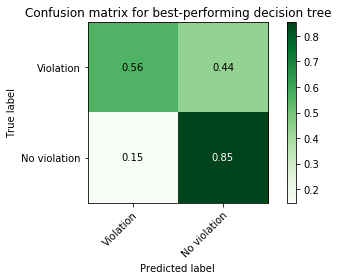

In [29]:
tree_1 = ppl.train_decision_tree(x_train[top_features], y_train, criterion='gini',splitter='best', max_depth=None)
pred_scores = tree_1.predict_proba(x_test[top_features])
pred_labels = [1 if x[1] > 0.3 else 0 for x in pred_scores]
ppl.plot_confusion_matrix(y_test, pred_labels, ['Violation','No violation'],
                         normalize=True, title="Confusion matrix for best-performing decision tree")

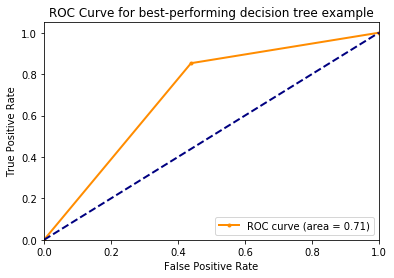

In [30]:
fpr, tpr, roc_auc = ppl.calculate_roc_curve(tree_1, x_test[top_features], y_test, 0.3)
ppl.plot_roc_curve(fpr, tpr, roc_auc, 'darkorange', 'ROC Curve for best-performing decision tree example')

In [33]:
len(y_test)

76840

In [34]:
sum(y_test)

19737

In [35]:
(76840-19737)/76840

0.743141592920354